In [1]:
import os
import numpy as np
import pandas as pd
from scipy.special import rel_entr
import scipy.stats as spstats

import pyscisci.all as pyscisci

import matplotlib.pyplot as plt

path2data = '/Users/hgt6rn/Desktop/APS'

In [2]:
myaps = pyscisci.APS(path2data)

# if this is your first time running the script, you need to run preprocess() below
#myaps.preprocess()

In [3]:
# load the data
pub = myaps.load_publications(columns = ['PublicationId', 'Year'])

pub2ref = myaps.load_references()


# and merge the dataframes to get citation years
pub2ref = pub2ref.merge(pub[['PublicationId', 'Year']], how='left',
                        left_on = 'CitedPublicationId', right_on = 'PublicationId')
pub2ref.rename(columns = {'Year':'CitedYear'}, inplace = True)
del pub2ref['PublicationId']

pub2ref = pub2ref.merge(pub[['PublicationId', 'Year']], how='left',
                        left_on = 'CitingPublicationId', right_on = 'PublicationId')

pub2ref.rename(columns = {'Year':'CitingYear'}, inplace = True)
del pub2ref['PublicationId']


Loading Publications:   0%|          | 0/1 [00:00<?, ?it/s]

Loading pub2ref:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# now we calculate the citation metrics
totalcites = pub2ref.groupby('CitedPublicationId', as_index=False)['CitingPublicationId'].nunique()
totalcites.rename(columns={'CitingPublicationId':'ctotal'}, inplace=True)

c10 = pub2ref[np.logical_and(pub2ref['CitingYear'] - pub2ref['CitedYear'] <= 10, 
                             pub2ref['CitingYear'] - pub2ref['CitedYear'] >=0)].groupby('CitedPublicationId', as_index=False)['CitingPublicationId'].nunique()
c10.rename(columns={'CitingPublicationId':'c10'}, inplace=True)

cnorm = pyscisci.netnormcite_index(pub2ref, T=10, show_progress=True)


Starting computation of network normalized index.


Network-normalized Citation:   0%|          | 0/563558 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
pub = pub.merge(cnorm, how='left', on = 'PublicationId')

pub = pub.merge(c10, how='left', left_on = 'PublicationId', right_on='CitedPublicationId')
del pub['CitedPublicationId']
pub = pub.merge(totalcites, how='left', left_on = 'PublicationId', right_on='CitedPublicationId')
del pub['CitedPublicationId']

pub.fillna(0, inplace=True)

pub['c10yearnorm'] = pub.groupby('Year')['c10'].transform(lambda x: x/x.mean())

#pub.to_csv(os.path.join(path2data, 'citecompare.csv.g'), compression='gzip', index=False, header=True)

In [10]:
#pub = pd.read_csv(os.path.join(path2data, 'citecompare.csv.gz'))


In [11]:
# in the paper, we only look at publications after 1945
pub10 = pub[pub['Year']>= 1945]

# since the citation window is 10 years, we can only look at publications before 2009
pub10 = pub10[pub10['Year']<=2009].reset_index(drop=True)



In [12]:
# now we calculate the entropy

def get_sorted_entropy(df, sortby = 'Cnorm10', base = np.e):
    entpts = np.zeros(50)
    years = df.sort_values(sortby, ascending = False)['Year'].values
    for i in range(50):
        ev = np.unique(years[:(1000 + i*1000)], return_counts = True)[1]
        ev = ev / np.sum(ev)
        entpts[i] = spstats.entropy(ev, base = base)
    return entpts

cnorment = get_sorted_entropy(pub10, sortby = 'Cnorm10')
c10ent = get_sorted_entropy(pub10, sortby = 'c10')
ctotalent = get_sorted_entropy(pub10, sortby = 'ctotal')
c10norment = get_sorted_entropy(pub10, sortby = 'c10yearnorm')

In [13]:
# now we calculate the KL divergence

year_counts = pub10['Year'].value_counts().to_frame().rename(columns={'Year':'count_q'}).reset_index().rename(columns={'index':'Year'})
year_counts['count_q'] = year_counts['count_q'] / np.sum(year_counts['count_q'])
year_counts

def get_sorted_kl(df, sortby = 'Cnorm10'):
    klpts = np.zeros(50)
    year_df = df.sort_values(sortby, ascending = False).reset_index(drop = True)
    
    for i in range(50):
        
        ydf = year_df.loc[:(1000+i*1000 - 1)]
        ydf = ydf['Year'].value_counts().to_frame().reset_index().rename(columns={'Year':'count_p', 'index':'Year'})
        ydf['count_p'] = ydf['count_p'] / np.sum(ydf['count_p'])
        ydf = ydf[['Year', 'count_p']].merge(year_counts, how = 'left', on = 'Year')
        klpts[i] = spstats.entropy(ydf['count_p'].values, ydf['count_q'].values)
        
    return klpts

cnorm_kl = get_sorted_kl(pub10, sortby = 'Cnorm10')
c10_kl = get_sorted_kl(pub10, sortby = 'c10')
ctotal_kl = get_sorted_kl(pub10, sortby = 'ctotal')
c10norm_kl = get_sorted_kl(pub10, sortby = 'c10yearnorm')

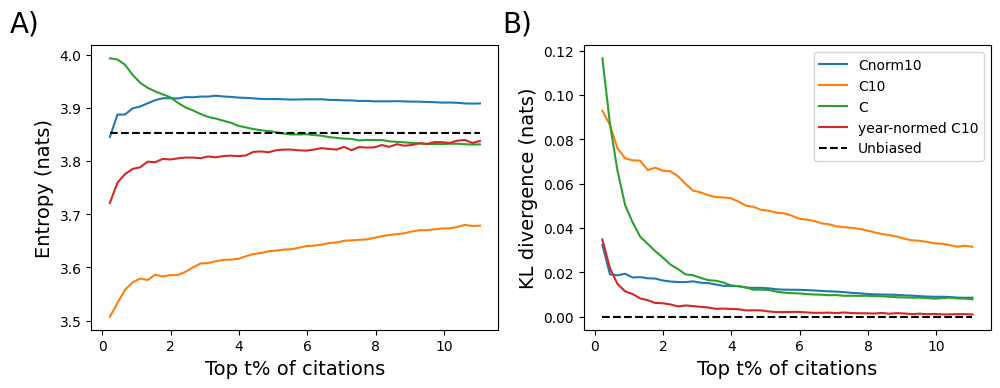

In [14]:
fig, ax = plt.subplots(1,2,figsize = (10,4))

xs = 100*np.arange(1000, 50001, 1000) / pub10.shape[0]

ax[0].plot(xs,cnorment, label = 'Cnorm10')
ax[0].plot(xs,c10ent, label = 'C10')
ax[0].plot(xs,ctotalent, label = 'C')
ax[0].plot(xs,c10norment, label = 'year-normed C10')

unbiased = pub10['Year'].value_counts().values
unbiased = unbiased / np.sum(unbiased)
ax[0].plot(xs,spstats.entropy(unbiased, base = np.e) * np.ones(50), ls = '--',
        color='k', label='Unbiased')


ax[1].plot(xs,cnorm_kl, label = 'Cnorm10')
ax[1].plot(xs,c10_kl, label = 'C10')
ax[1].plot(xs,ctotal_kl, label = 'C')
ax[1].plot(xs,c10norm_kl, label = 'year-normed C10')

ax[1].plot(xs, np.zeros(50), ls = '--',
        color='k', label='Unbiased')

ax[0].set_ylabel('Entropy (nats)', fontsize=14)
ax[1].set_ylabel('KL divergence (nats)', fontsize=14)


for iax in range(2):
    ax[iax].set_xlabel('Top t% of citations', fontsize=14)    

plt.legend()

ax[0].text(-0.2, 1.05, 'A)', fontsize=20, transform=ax[0].transAxes)
ax[1].text(-0.2, 1.05, 'B)', fontsize=20, transform=ax[1].transAxes)

plt.tight_layout()
plt.savefig(os.path.join(path2data, 'aps_year_comparison.png'))
plt.savefig(os.path.join(path2data, 'aps_year_comparison.pdf'))
plt.show()